# League of Legends Champion Analysis

This notebook contains analyses of champion performance, winrates, and matchups from ranked solo matches.

**Player**: tattpåfersken (EUNE)  
**Period**: August 2024 - Present  
**Queue**: Ranked Solo/Duo (420)

## Goal

My goal was to reach Diamond rank. At the beginning of 2025, my peak rank was Emerald 4. By the end of 2025, I reached Diamond 4. This notebook analyzes my gameplay data to understand what factors contributed to this progression, including champion synergies, item choices, objective control, and playstyle changes.


---

## Champion Winrates (Zoe Games) {#champion-winrates-zoe-games}

Analyze winrates with teammates and against enemies for matches where you played Zoe.

**Questions:**
- Which champions do you win most with when playing Zoe?
- Which enemy champions do you struggle against when playing Zoe?
- Are there specific champion combinations that work well with Zoe?


/tmp/ipykernel_44569/1352219734.py:11: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  df['gameDate'] = pd.to_datetime(df['gameDate'])


Total matches: 299
Zoe games: 183
Zoe win rate: 54.6%

Processed 183 Zoe matches
Found 141 unique teammate champions
Found 164 unique enemy champions


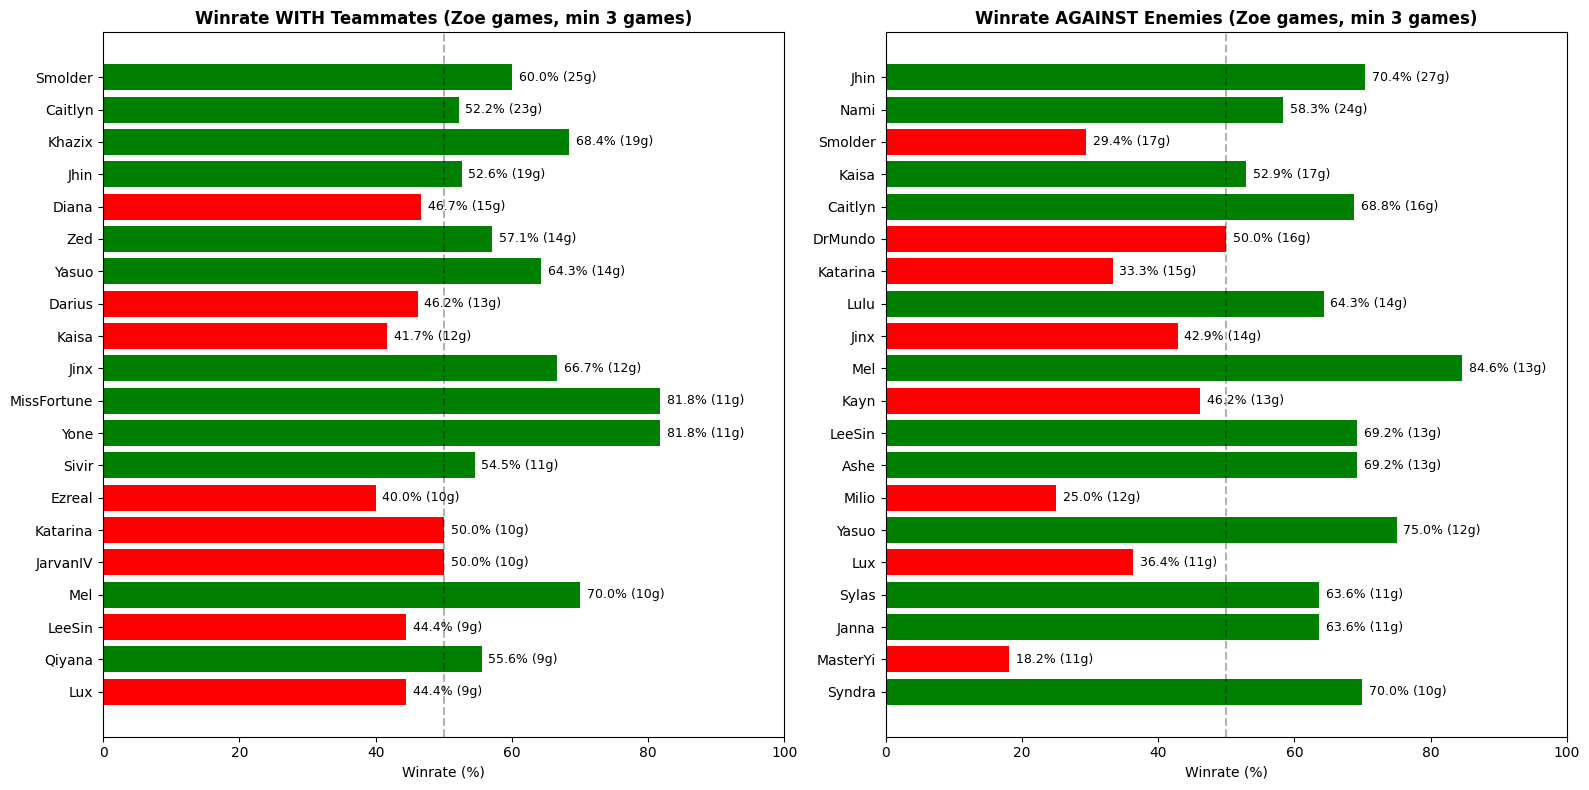

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import json
from IPython.display import HTML, display

# Load the match data
df = pd.read_csv('../data/lol_matches.csv')
df['gameDate'] = pd.to_datetime(df['gameDate'])

# Filter to Zoe games only
zoe_games = df[df['championName'] == 'Zoe'].copy()
print(f"Total matches: {len(df)}")
print(f"Zoe games: {len(zoe_games)}")
print(f"Zoe win rate: {(zoe_games['win'].mean() * 100):.1f}%")

# Load the raw match data
with open('../data/lol_matches_raw.json', 'r') as f:
    raw_matches = json.load(f)
match_dict = {match['metadata']['matchId']: match for match in raw_matches}

# Get match IDs for Zoe games
zoe_match_ids = set(zoe_games['matchId'].values)

# Get PUUID from the first match
sample_match_id = zoe_games.iloc[0]['matchId']
sample_match = match_dict.get(sample_match_id)
your_puuid = None
if sample_match:
    participants = sample_match['info']['participants']
    for p in participants:
        if p['championName'] == 'Zoe':
            your_puuid = p['puuid']
            break

# Analyze winrates with teammates and against enemies
champions_with = defaultdict(lambda: {'wins': 0, 'games': 0})
champions_against = defaultdict(lambda: {'wins': 0, 'games': 0})

for match_id in zoe_match_ids:
    match_data = match_dict.get(match_id)
    if not match_data:
        continue
    
    info = match_data['info']
    participants = info['participants']
    
    your_team_id = None
    match_result = None
    
    for p in participants:
        if p['puuid'] == your_puuid:
            your_team_id = p['teamId']
            match_result = p['win']
            break
    
    if your_team_id is None:
        continue
    
    for p in participants:
        if p['puuid'] == your_puuid:
            continue
        
        champ_name = p['championName']
        
        if p['teamId'] == your_team_id:
            champions_with[champ_name]['games'] += 1
            if match_result:
                champions_with[champ_name]['wins'] += 1
        else:
            champions_against[champ_name]['games'] += 1
            if match_result:
                champions_against[champ_name]['wins'] += 1

# Calculate winrates and create DataFrames
def create_winrate_df(champ_dict, title_prefix):
    data = []
    for champ, stats in champ_dict.items():
        winrate = (stats['wins'] / stats['games'] * 100) if stats['games'] > 0 else 0
        data.append({
            'Champion': champ,
            'Games': stats['games'],
            'Wins': stats['wins'],
            'Losses': stats['games'] - stats['wins'],
            'Winrate': winrate
        })
    
    df_result = pd.DataFrame(data)
    df_result = df_result.sort_values('Games', ascending=False)
    return df_result

teammates_df = create_winrate_df(champions_with, 'With')
enemies_df = create_winrate_df(champions_against, 'Against')

print(f"\nProcessed {len(zoe_match_ids)} Zoe matches")
print(f"Found {len(champions_with)} unique teammate champions")
print(f"Found {len(champions_against)} unique enemy champions")

# Visualizations
fig, axes = plt.subplots(1, 2, figsize=(16, 8))
min_games = 3

# Teammates
teammates_filtered = teammates_df[teammates_df['Games'] >= min_games].head(20)
ax1 = axes[0]
bars1 = ax1.barh(range(len(teammates_filtered)), teammates_filtered['Winrate'], 
                 color=['green' if w > 50 else 'red' for w in teammates_filtered['Winrate']])
ax1.set_yticks(range(len(teammates_filtered)))
ax1.set_yticklabels(teammates_filtered['Champion'])
ax1.set_xlabel('Winrate (%)')
ax1.set_title(f'Winrate WITH Teammates (Zoe games, min {min_games} games)', fontsize=12, fontweight='bold')
ax1.axvline(x=50, color='black', linestyle='--', alpha=0.3)
ax1.set_xlim(0, 100)
ax1.invert_yaxis()

for i, (idx, row) in enumerate(teammates_filtered.iterrows()):
    ax1.text(row['Winrate'] + 1, i, f"{row['Winrate']:.1f}% ({row['Games']}g)", 
             va='center', fontsize=9)

# Enemies
enemies_filtered = enemies_df[enemies_df['Games'] >= min_games].head(20)
ax2 = axes[1]
bars2 = ax2.barh(range(len(enemies_filtered)), enemies_filtered['Winrate'],
                 color=['green' if w > 50 else 'red' for w in enemies_filtered['Winrate']])
ax2.set_yticks(range(len(enemies_filtered)))
ax2.set_yticklabels(enemies_filtered['Champion'])
ax2.set_xlabel('Winrate (%)')
ax2.set_title(f'Winrate AGAINST Enemies (Zoe games, min {min_games} games)', fontsize=12, fontweight='bold')
ax2.axvline(x=50, color='black', linestyle='--', alpha=0.3)
ax2.set_xlim(0, 100)
ax2.invert_yaxis()

for i, (idx, row) in enumerate(enemies_filtered.iterrows()):
    ax2.text(row['Winrate'] + 1, i, f"{row['Winrate']:.1f}% ({row['Games']}g)", 
             va='center', fontsize=9)

plt.tight_layout()
plt.show()

# Create copy-friendly data output (filtered to champions with at least 5 games)
min_games_for_copy = 5
teammates_filtered_copy = teammates_df[teammates_df['Games'] >= min_games_for_copy]
enemies_filtered_copy = enemies_df[enemies_df['Games'] >= min_games_for_copy]

copy_data = {
    'teammates': teammates_filtered_copy.to_dict('records'),
    'enemies': enemies_filtered_copy.to_dict('records'),
    'zoe_overall_winrate': float(zoe_games['win'].mean() * 100),
    'total_zoe_games': len(zoe_games),
    'min_games_filter': min_games_for_copy
}

import json as json_module
copy_text = json_module.dumps(copy_data, indent=2)

# Create HTML with copy button
copy_html = f'''
<div style="margin-top: 20px; padding: 10px; border: 1px solid #ccc; border-radius: 5px;">
    <h4 style="margin-top: 0;">Copy Data for AI Analysis</h4>
    <button onclick="copyToClipboard()" style="padding: 8px 16px; background: #4CAF50; color: white; border: none; border-radius: 4px; cursor: pointer; font-size: 14px;">
        📋 Copy Data
    </button>
    <pre id="dataOutput" style="display: none;">{copy_text}</pre>
    <script>
        function copyToClipboard() {{
            const text = document.getElementById('dataOutput').textContent;
            navigator.clipboard.writeText(text).then(function() {{
                alert('Data copied to clipboard!');
            }}, function(err) {{
                console.error('Failed to copy: ', err);
            }});
        }}
    </script>
</div>
'''

display(HTML(copy_html))


### Interpretation & Limitations

When interpreting champion winrate data, two critical factors determine whether a result is meaningful:

**1. Sample Size**: I think that a minimum of ~10 games is needed for any winrate to be statistically meaningful. Small sample sizes are highly susceptible to variance since a champion could appear strong or weak simply due to luck or the specific game contexts in which they appeared.

**2. Winrate Magnitude**: A 52% winrate with 20 games might just be noise, while a 70% winrate with 19 games (like Kha'Zix at 68.4%) represents a substantial signal. The larger the percentage difference from overall winrate (54.6% with Zoe), the more likely it reflects genuine synergy or counter patterns.

### Key Insights

**Champions That Do Well With Zoe**:
- **Kha'Zix** (68.4% WR, 19 games): Strong synergy with nearly 14 percentage points above baseline. His ability to follow up on Zoe's bubble with isolated damage, combined with early to mid game skirmish pressure, creates insane synergy.
- **Yone/Miss Fortune** (81.8% WR, 11 games): While sample size is borderline, the winrate is exceptional. These champions excel at following up on Zoe's setup, particularly MF's ultimate and Yone's all-in potential.
- **Jinx** (66.7% WR, 12 games): Strong follow-up potential with her long-range damage and ability to capitalize on Zoe's CC.

**Champions That Counter Zoe**:
- **Katarina**: This one is obvious, as kata is a known counter to low mobility champions like Zoe, which struggle against all-in assassins who can jump on her.
- **Auto-attack heavy champions**: Champions that can consistently auto-attack Zoe are problematic because they can catch her easily and don't rely on skillshots that Zoe can dodge with her mobility.

**Why Champions Do Well With Zoe**:
The data shows a clear pattern: champions that synergize well with Zoe fall into two categories. First, champions that excel in early to mid game skirmishes and can follow up on Zoe's bubble setup, like Kha'Zix. These champions create pressure that complements Zoe's pick potential and playmaking. Second, champions with strong follow-up abilities that can capitalize on Zoe's CC, such as Miss Fortune's R or Jhin's W follow-up. The key is having champions that can convert Zoe's bubble hits into kills and snowball advantages.

**Why Champions Counter Zoe**:
Zoe's main weaknesses are her low mobility and vulnerability to dive champions. Auto-attack heavy champions are particularly problematic because they can consistently catch Zoe and don't rely on skillshots that she can dodge. All-in champions like Katarina can jump on Zoe and burst her down before she can escape, exploiting her lack of reliable mobility tools. This creates a pattern where Zoe struggles most against champions that can either out-sustain her poke with consistent auto-attacks or bypass her skillshot-based defense with gap-closers and all-in potential.


---

## Luden's vs Shurelya's Comparison {#ludens-vs-shurelyas}

Compare performance metrics between games where you built Luden's Companion vs Shurelya's Battlesong.

**Questions:**
- Which item has a higher winrate?
- How does damage output differ?
- Are there differences in deaths, KDA, or other stats?
- When is each item more effective?


In [1]:
# Setup: Filter Zoe games by item and create statistical comparison
if 'pd' not in locals() and 'pd' not in globals():
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt

if 'zoe_games' not in locals() and 'zoe_games' not in globals():
    if 'df' not in locals() and 'df' not in globals():
        df = pd.read_csv('../data/lol_matches.csv')
        df['gameDate'] = pd.to_datetime(df['gameDate'])
    zoe_games = df[df['championName'] == 'Zoe'].copy()

# Item IDs: Luden's Companion = 6655, Shurelya's Battlesong = 2065
LUDENS_ITEM_ID = 6655
SHURELYAS_ITEM_ID = 2065

# Filter Zoe games by item
def get_mythic_item(row):
    for i in range(7):
        item_id = row.get(f'item{i}', 0)
        if item_id == LUDENS_ITEM_ID:
            return 'Ludens'
        elif item_id == SHURELYAS_ITEM_ID:
            return 'Shurelyas'
    return None

zoe_games_with_items = zoe_games.copy()
zoe_games_with_items['mythic_item'] = zoe_games_with_items.apply(get_mythic_item, axis=1)
ludens_shurelyas_games = zoe_games_with_items[zoe_games_with_items['mythic_item'].notna()].copy()

ludens_games = ludens_shurelyas_games[ludens_shurelyas_games['mythic_item'] == 'Ludens']
shurelyas_games = ludens_shurelyas_games[ludens_shurelyas_games['mythic_item'] == 'Shurelyas']

# Statistical comparison table
comparison_stats = ['win', 'kills', 'deaths', 'assists', 'kda', 
                    'totalDamageDealtToChampions', 'damagePerMin',
                    'goldEarned', 'goldPerMin', 'csPerMin', 
                    'visionScore', 'visionScorePerMin', 'killParticipation']

comparison_data = []
for stat in comparison_stats:
    ludens_mean = ludens_games[stat].mean()
    shurelyas_mean = shurelyas_games[stat].mean()
    difference = ludens_mean - shurelyas_mean
    pct_diff = (difference / shurelyas_mean * 100) if shurelyas_mean != 0 else 0
    
    comparison_data.append({
        'Stat': stat,
        'Ludens': round(ludens_mean, 2),
        'Shurelyas': round(shurelyas_mean, 2),
        'Difference': round(difference, 2),
        '% Difference': round(pct_diff, 1)
    })

comparison_table = pd.DataFrame(comparison_data)

print("=" * 70)
print("STATISTICAL COMPARISON: LUDEN'S vs SHURELYA'S")
print("=" * 70)
print(comparison_table.to_string(index=False))
print(f"\nSample sizes: Luden's: {len(ludens_games)} games | Shurelya's: {len(shurelyas_games)} games")


STATISTICAL COMPARISON: LUDEN'S vs SHURELYA'S
                       Stat   Ludens  Shurelyas  Difference  % Difference
                        win     0.56       0.55        0.02           3.0
                      kills     3.88       3.97       -0.09          -2.3
                     deaths     5.60       5.78       -0.18          -3.1
                    assists    11.56      13.53       -1.97         -14.5
                        kda     4.09       4.68       -0.59         -12.6
totalDamageDealtToChampions 21381.88   20983.51      398.36           1.9
               damagePerMin   708.27     655.52       52.75           8.0
                 goldEarned  9650.40   10063.70     -413.30          -4.1
                 goldPerMin   325.17     320.98        4.19           1.3
                   csPerMin     1.51       1.41        0.10           7.3
                visionScore    58.85      70.22      -11.36         -16.2
          visionScorePerMin     1.96       2.23       -0.27       

/tmp/ipykernel_88265/2388739306.py:10: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  df['gameDate'] = pd.to_datetime(df['gameDate'])


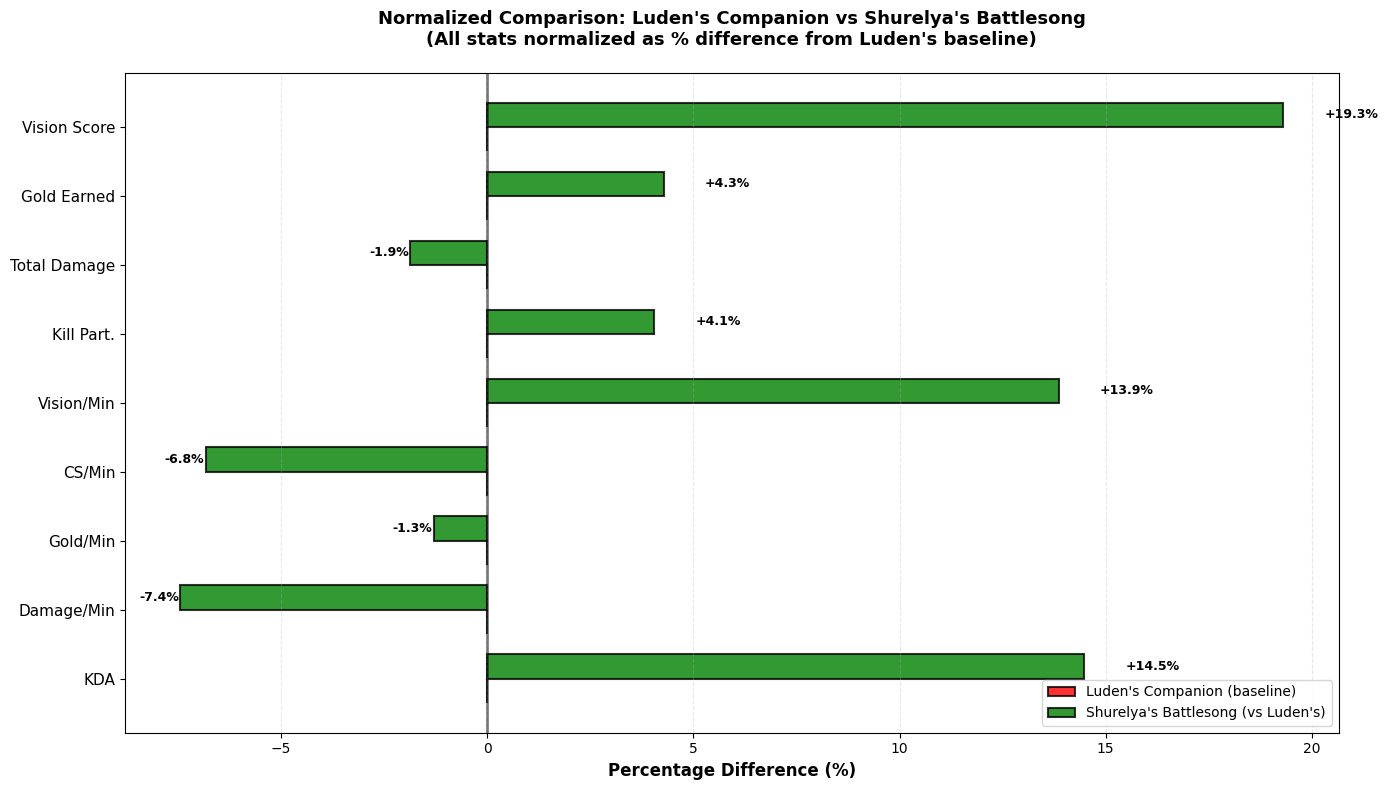

In [2]:
# Normalized percentage comparison chart
comparison_stats_normalized = {
    'KDA': 'kda',
    'Damage/Min': 'damagePerMin',
    'Gold/Min': 'goldPerMin',
    'CS/Min': 'csPerMin',
    'Vision/Min': 'visionScorePerMin',
    'Kill Part.': 'killParticipation',
    'Total Damage': 'totalDamageDealtToChampions',
    'Gold Earned': 'goldEarned',
    'Vision Score': 'visionScore'
}

# Calculate percentage differences (Shurelya's relative to Luden's)
normalized_data = []
for label, stat in comparison_stats_normalized.items():
    ludens_val = ludens_games[stat].mean()
    shurelyas_val = shurelyas_games[stat].mean()
    
    if ludens_val != 0:
        pct_diff = ((shurelyas_val - ludens_val) / ludens_val) * 100
    else:
        pct_diff = 0
    
    normalized_data.append({
        'Stat': label,
        'Luden\'s %': 0,  # Baseline at 0%
        'Shurelya\'s %': pct_diff
    })

normalized_df = pd.DataFrame(normalized_data)

# Create the visualization
fig, ax = plt.subplots(figsize=(14, 8))

x = np.arange(len(normalized_df))
width = 0.35

# Create bars - Luden's at baseline (0), Shurelya's as percentage difference
# Red for Luden's, Green for Shurelya's
ludens_values = normalized_df['Luden\'s %'].values
shurelyas_values = normalized_df['Shurelya\'s %'].values

# Create bars with explicit colors
bars1 = ax.barh(x - width/2, ludens_values, width, 
                label='Luden\'s Companion (baseline)', 
                color='red', alpha=0.8, edgecolor='black', linewidth=1.5)
bars2 = ax.barh(x + width/2, shurelyas_values, width,
                label='Shurelya\'s Battlesong (vs Luden\'s)', 
                color='green', alpha=0.8, edgecolor='black', linewidth=1.5)

# Force set colors explicitly using facecolor (more reliable than color)
for i, bar in enumerate(bars1):
    bar.set_facecolor('red')
    bar.set_edgecolor('black')
for i, bar in enumerate(bars2):
    bar.set_facecolor('green')
    bar.set_edgecolor('black')

# Add value labels on bars
for i, (idx, row) in enumerate(normalized_df.iterrows()):
    shurelyas_pct = row['Shurelya\'s %']
    ax.text(0 + (1 if 0 > 0 else -1), i - width/2,
            '0.0%', va='center', fontweight='bold', fontsize=9, color='white')
    if abs(shurelyas_pct) > 1:
        ax.text(shurelyas_pct + (1 if shurelyas_pct > 0 else -1), i + width/2, 
                f'{shurelyas_pct:+.1f}%', va='center', fontweight='bold', fontsize=9)

ax.set_xlabel('Percentage Difference (%)', fontsize=12, fontweight='bold')
ax.set_title('Normalized Comparison: Luden\'s Companion vs Shurelya\'s Battlesong\n(All stats normalized as % difference from Luden\'s baseline)', 
             fontsize=13, fontweight='bold', pad=20)
ax.set_yticks(x)
ax.set_yticklabels(normalized_df['Stat'], fontsize=11)
ax.axvline(x=0, color='black', linestyle='-', linewidth=2, alpha=0.5)
ax.legend(loc='lower right', fontsize=10)
ax.grid(axis='x', alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()


---

## Ionian Boots vs Crimson Lucidity {#ionian-boots-vs-crimson-lucidity}

Compare performance metrics between games where you ended with Ionian Boots of Lucidity vs Crimson Lucidity (Feats of Strength completion).

**Questions:**
- Which boots item has a higher winrate?
- How does damage output differ?
- Are there differences in deaths, KDA, or other stats?
- When is each item more effective?


In [4]:
# Setup: Filter Zoe games by item and create statistical comparison
if 'pd' not in locals() and 'pd' not in globals():
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt

if 'zoe_games' not in locals() and 'zoe_games' not in globals():
    if 'df' not in locals() and 'df' not in globals():
        df = pd.read_csv('../data/lol_matches.csv')
        df['gameDate'] = pd.to_datetime(df['gameDate'])
    zoe_games = df[df['championName'] == 'Zoe'].copy()

# Item IDs: Ionian Boots of Lucidity = 3158, Crimson Lucidity = 6690
IONIAN_BOOTS_ITEM_ID = 3158
CRIMSON_LUCIDITY_ITEM_ID = 3171

# Filter Zoe games by item
def get_boots_item(row):
    for i in range(7):
        item_id = row.get(f'item{i}', 0)
        if item_id == IONIAN_BOOTS_ITEM_ID:
            return 'Ionian Boots'
        elif item_id == CRIMSON_LUCIDITY_ITEM_ID:
            return 'Crimson Lucidity'
    return None

zoe_games_with_boots = zoe_games.copy()
zoe_games_with_boots['boots_item'] = zoe_games_with_boots.apply(get_boots_item, axis=1)
ionian_crimson_games = zoe_games_with_boots[zoe_games_with_boots['boots_item'].notna()].copy()

ionian_boots_games = ionian_crimson_games[ionian_crimson_games['boots_item'] == 'Ionian Boots']
crimson_lucidity_games = ionian_crimson_games[ionian_crimson_games['boots_item'] == 'Crimson Lucidity']

# Statistical comparison table
comparison_stats = ['win', 'kills', 'deaths', 'assists', 'kda', 
                    'totalDamageDealtToChampions', 'damagePerMin',
                    'goldEarned', 'goldPerMin', 'csPerMin', 
                    'visionScore', 'visionScorePerMin', 'killParticipation']

comparison_data = []

# Add Winrate row first (as percentage)
ionian_winrate = ionian_boots_games['win'].mean() * 100
crimson_winrate = crimson_lucidity_games['win'].mean() * 100
winrate_diff = ionian_winrate - crimson_winrate
winrate_pct_diff = (winrate_diff / crimson_winrate * 100) if crimson_winrate != 0 else 0

comparison_data.append({
    'Stat': 'Winrate (%)',
    'Ionian Boots': round(ionian_winrate, 1),
    'Crimson Lucidity': round(crimson_winrate, 1),
    'Difference': round(winrate_diff, 1),
    '% Difference': round(winrate_pct_diff, 1)
})

# Add other stats
for stat in comparison_stats:
    ionian_mean = ionian_boots_games[stat].mean()
    crimson_mean = crimson_lucidity_games[stat].mean()
    difference = ionian_mean - crimson_mean
    pct_diff = (difference / crimson_mean * 100) if crimson_mean != 0 else 0
    
    comparison_data.append({
        'Stat': stat,
        'Ionian Boots': round(ionian_mean, 2),
        'Crimson Lucidity': round(crimson_mean, 2),
        'Difference': round(difference, 2),
        '% Difference': round(pct_diff, 1)
    })

comparison_table = pd.DataFrame(comparison_data)

print("=" * 70)
print("STATISTICAL COMPARISON: IONIAN BOOTS vs CRIMSON LUCIDITY")
print("=" * 70)
print(comparison_table.to_string(index=False))
print(f"\nSample sizes: Ionian Boots: {len(ionian_boots_games)} games | Crimson Lucidity: {len(crimson_lucidity_games)} games")


STATISTICAL COMPARISON: IONIAN BOOTS vs CRIMSON LUCIDITY
                       Stat  Ionian Boots  Crimson Lucidity  Difference  % Difference
                Winrate (%)         33.30             75.60      -42.30         -55.9
                        win          0.33              0.76       -0.42         -55.9
                      kills          3.38              4.10       -0.71         -17.4
                     deaths          6.22              5.20        1.02          19.7
                    assists         11.05             14.48       -3.42         -23.7
                        kda          3.26              5.00       -1.74         -34.8
totalDamageDealtToChampions      19164.33          21895.51    -2731.18         -12.5
               damagePerMin        617.54            684.90      -67.36          -9.8
                 goldEarned       9291.21          10371.62    -1080.42         -10.4
                 goldPerMin        304.61            332.27      -27.66          -8

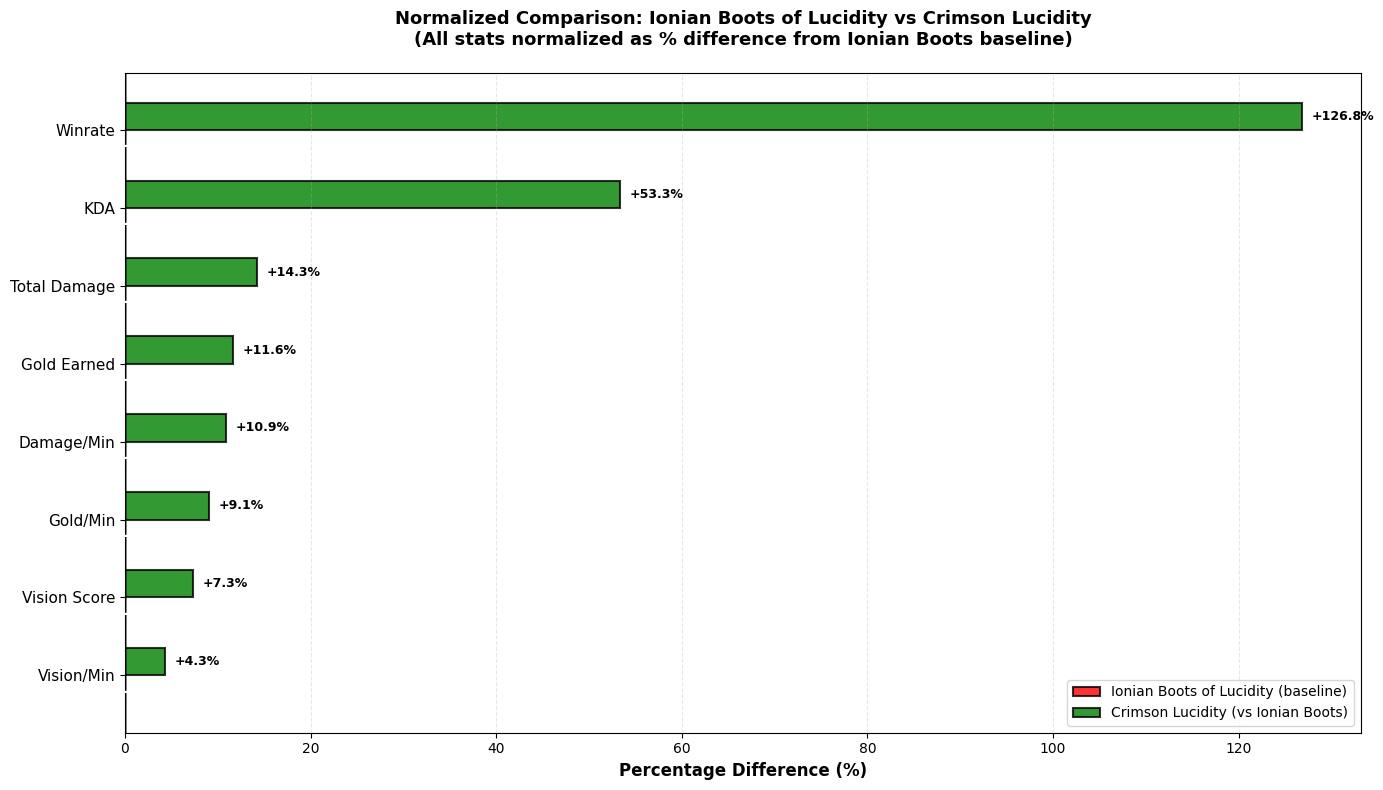

In [5]:
# Normalized percentage comparison chart
comparison_stats_normalized = {
    'Winrate': 'win',
    'KDA': 'kda',
    'Damage/Min': 'damagePerMin',
    'Gold/Min': 'goldPerMin',
    'Vision/Min': 'visionScorePerMin',
    'Total Damage': 'totalDamageDealtToChampions',
    'Gold Earned': 'goldEarned',
    'Vision Score': 'visionScore'
}

# Calculate percentage differences (Crimson Lucidity relative to Ionian Boots)
normalized_data = []
for label, stat in comparison_stats_normalized.items():
    ionian_val = ionian_boots_games[stat].mean()
    crimson_val = crimson_lucidity_games[stat].mean()
    
    # For winrate, convert to percentage for display
    if stat == 'win':
        ionian_val = ionian_val * 100
        crimson_val = crimson_val * 100
    
    if ionian_val != 0:
        pct_diff = ((crimson_val - ionian_val) / ionian_val) * 100
    else:
        pct_diff = 0
    
    normalized_data.append({
        'Stat': label,
        'Ionian Boots %': 0,  # Baseline at 0%
        'Crimson Lucidity %': pct_diff
    })

normalized_df = pd.DataFrame(normalized_data)

# Sort by absolute percentage difference (biggest difference at top)
# Sort ascending so biggest appears at top (barh displays first row at bottom)
normalized_df['abs_diff'] = normalized_df['Crimson Lucidity %'].abs()
normalized_df = normalized_df.sort_values('abs_diff', ascending=True).drop('abs_diff', axis=1)

# Create the visualization
fig, ax = plt.subplots(figsize=(14, 8))

x = np.arange(len(normalized_df))
width = 0.35

# Create bars - Ionian Boots at baseline (0), Crimson Lucidity as percentage difference
# Red for Ionian Boots, Green for Crimson Lucidity
ionian_values = normalized_df['Ionian Boots %'].values
crimson_values = normalized_df['Crimson Lucidity %'].values

# Create bars with explicit colors
bars1 = ax.barh(x - width/2, ionian_values, width, 
                label='Ionian Boots of Lucidity (baseline)', 
                color='red', alpha=0.8, edgecolor='black', linewidth=1.5)
bars2 = ax.barh(x + width/2, crimson_values, width,
                label='Crimson Lucidity (vs Ionian Boots)', 
                color='green', alpha=0.8, edgecolor='black', linewidth=1.5)

# Force set colors explicitly using facecolor (more reliable than color)
for i, bar in enumerate(bars1):
    bar.set_facecolor('red')
    bar.set_edgecolor('black')
for i, bar in enumerate(bars2):
    bar.set_facecolor('green')
    bar.set_edgecolor('black')

# Add value labels on bars
for i, (idx, row) in enumerate(normalized_df.iterrows()):
    crimson_pct = row['Crimson Lucidity %']
    ax.text(0 + (1 if 0 > 0 else -1), i - width/2,
            '0.0%', va='center', fontweight='bold', fontsize=9, color='white')
    if abs(crimson_pct) > 1:
        ax.text(crimson_pct + (1 if crimson_pct > 0 else -1), i + width/2, 
                f'{crimson_pct:+.1f}%', va='center', fontweight='bold', fontsize=9)

ax.set_xlabel('Percentage Difference (%)', fontsize=12, fontweight='bold')
ax.set_title('Normalized Comparison: Ionian Boots of Lucidity vs Crimson Lucidity\n(All stats normalized as % difference from Ionian Boots baseline)', 
             fontsize=13, fontweight='bold', pad=20)
ax.set_yticks(x)
ax.set_yticklabels(normalized_df['Stat'], fontsize=11)
ax.axvline(x=0, color='black', linestyle='-', linewidth=2, alpha=0.5)
ax.legend(loc='lower right', fontsize=10)
ax.grid(axis='x', alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()


## Atakhan Impact Analysis

Analyze the impact of killing Atakhan (neutral objective) on game outcomes.

**Questions:**
- What's the winrate when your team kills Atakhan vs when they don't?
- How impactful is securing Atakhan for winning games?


/tmp/ipykernel_88265/2964964818.py:10: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  df['gameDate'] = pd.to_datetime(df['gameDate'])


ATAKHAN IMPACT ANALYSIS

2x2 Contingency Table:
win             False  True  All
atakhan_killed                  
False             112    52  164
True               28   107  135
All               140   159  299

Winrate when team killed Atakhan: 79.3% (135 games)
Winrate when team did NOT kill Atakhan: 31.7% (164 games)
Difference: 47.6 percentage points


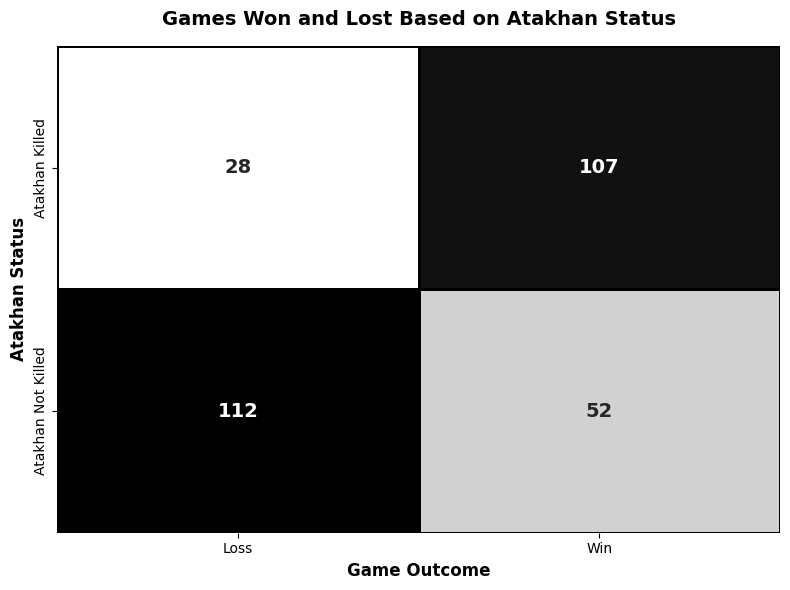


Summary:
  Games where team killed Atakhan: 135 (79.3% winrate)
  Games where team did NOT kill Atakhan: 164 (31.7% winrate)
  Difference: 47.6 percentage points


In [6]:
# Analyze Atakhan impact
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json

# Load data
df = pd.read_csv('../data/lol_matches.csv')
df['gameDate'] = pd.to_datetime(df['gameDate'])

# Load raw match data
with open('../data/lol_matches_raw.json', 'r') as f:
    raw_matches = json.load(f)
match_dict = {match['metadata']['matchId']: match for match in raw_matches}

# Analyze Atakhan kills and win/loss
atakhan_data = []

for idx, row in df.iterrows():
    match_id = row['matchId']
    match_data = match_dict.get(match_id)
    
    if not match_data:
        continue
    
    your_team_id = row['teamId']
    match_result = row['win']
    
    # Get Atakhan kills for your team
    teams = match_data['info']['teams']
    your_team_atakhan_kills = 0
    
    for team in teams:
        if team['teamId'] == your_team_id:
            your_team_atakhan_kills = team.get('objectives', {}).get('atakhan', {}).get('kills', 0)
            break
    
    atakhan_data.append({
        'matchId': match_id,
        'win': match_result,
        'atakhan_killed': your_team_atakhan_kills > 0,
        'atakhan_kills': your_team_atakhan_kills
    })

atakhan_df = pd.DataFrame(atakhan_data)

# Create 2x2 contingency table
contingency = pd.crosstab(
    atakhan_df['atakhan_killed'], 
    atakhan_df['win'], 
    margins=True
)

print("=" * 70)
print("ATAKHAN IMPACT ANALYSIS")
print("=" * 70)
print("\n2x2 Contingency Table:")
print(contingency)
print()

# Calculate winrates
atakhan_killed_winrate = atakhan_df[atakhan_df['atakhan_killed'] == True]['win'].mean() * 100
atakhan_not_killed_winrate = atakhan_df[atakhan_df['atakhan_killed'] == False]['win'].mean() * 100

atakhan_killed_count = len(atakhan_df[atakhan_df['atakhan_killed'] == True])
atakhan_not_killed_count = len(atakhan_df[atakhan_df['atakhan_killed'] == False])

print(f"Winrate when team killed Atakhan: {atakhan_killed_winrate:.1f}% ({atakhan_killed_count} games)")
print(f"Winrate when team did NOT kill Atakhan: {atakhan_not_killed_winrate:.1f}% ({atakhan_not_killed_count} games)")
print(f"Difference: {atakhan_killed_winrate - atakhan_not_killed_winrate:.1f} percentage points")

# Prepare data for visualization
table_data = pd.crosstab(
    atakhan_df['atakhan_killed'].map({True: 'Atakhan Killed', False: 'Atakhan Not Killed'}),
    atakhan_df['win'].map({True: 'Win', False: 'Loss'}),
    margins=False
)

table_data = table_data[['Loss', 'Win']]

# Calculate winrates for summary
atakhan_killed_total = table_data.loc['Atakhan Killed', 'Win'] + table_data.loc['Atakhan Killed', 'Loss']
atakhan_not_killed_total = table_data.loc['Atakhan Not Killed', 'Win'] + table_data.loc['Atakhan Not Killed', 'Loss']
atakhan_killed_wr = (table_data.loc['Atakhan Killed', 'Win'] / atakhan_killed_total * 100) if atakhan_killed_total > 0 else 0
atakhan_not_killed_wr = (table_data.loc['Atakhan Not Killed', 'Win'] / atakhan_not_killed_total * 100) if atakhan_not_killed_total > 0 else 0

# Create contingency table heatmap
fig, ax = plt.subplots(figsize=(8, 6))

sns.heatmap(table_data, annot=True, fmt='d', 
            linewidths=2, linecolor='black', ax=ax, 
            annot_kws={'size': 14, 'weight': 'bold'},
            cbar=False,
            cmap='Greys',
            vmin=table_data.min().min(),
            vmax=table_data.max().max())

# Get values for each cell
ak_loss = table_data.loc['Atakhan Killed', 'Loss']
ak_win = table_data.loc['Atakhan Killed', 'Win']
ank_loss = table_data.loc['Atakhan Not Killed', 'Loss']
ank_win = table_data.loc['Atakhan Not Killed', 'Win']

# Normalize values for grayscale
all_values = [ak_loss, ak_win, ank_loss, ank_win]
value_min = min(all_values)
value_max = max(all_values)
value_range = value_max - value_min if value_max > value_min else 1

def get_grayscale(value):
    if value_range > 0:
        intensity = (value - value_min) / value_range
        gray = 1.0 - intensity
        return (gray, gray, gray)
    else:
        return (0.5, 0.5, 0.5)

ak_loss_color = get_grayscale(ak_loss)
ak_win_color = get_grayscale(ak_win)
ank_loss_color = get_grayscale(ank_loss)
ank_win_color = get_grayscale(ank_win)

# Set colors for each cell
rect_patches = [p for p in ax.patches if hasattr(p, 'get_width') and p.get_width() > 0 and p.get_height() > 0]

if len(rect_patches) >= 4:
    colors = [ak_loss_color, ak_win_color, ank_loss_color, ank_win_color]
    for i, patch in enumerate(rect_patches[:4]):
        patch.set_facecolor(colors[i])
        patch.set_color(colors[i])
        patch.set_edgecolor('black')
        patch.set_linewidth(2)

ax.set_title('Games Won and Lost Based on Atakhan Status', fontsize=14, fontweight='bold', pad=15)
ax.set_xlabel('Game Outcome', fontsize=12, fontweight='bold')
ax.set_ylabel('Atakhan Status', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

print(f"\nSummary:")
print(f"  Games where team killed Atakhan: {atakhan_killed_total} ({atakhan_killed_wr:.1f}% winrate)")
print(f"  Games where team did NOT kill Atakhan: {atakhan_not_killed_total} ({atakhan_not_killed_wr:.1f}% winrate)")
print(f"  Difference: {atakhan_killed_wr - atakhan_not_killed_wr:.1f} percentage points")


### Interpretation & Insights

**Limitation**: The correlation between Atakhan and wins is heavily confounded by game state. Teams that secure Atakhan are typically already ahead—they have map control, vision, and the ability to contest objectives. This creates a feedback loop where winning teams get Atakhan, and Atakhan helps them win more. The 47.6 percentage point difference doesn't mean Atakhan causes wins; it means winning teams secure Atakhan more often.

**Interesting Pattern**: There's an asymmetry in the data that reveals something important about how games play out:
- **52 wins without Atakhan** vs **28 losses with Atakhan** (ratio ~1.86:1)

This pattern suggests two things:

1. **Winning without Atakhan is more common than losing with it**: You can win games through superior macro, teamfighting, or early game advantages without needing Atakhan. The fact that you won 52 games without securing this powerful objective shows that Atakhan isn't always necessary for victory—strong fundamentals can carry games.

2. **When you have Atakhan, losses are rare**: Only 28 out of 135 games (20.7%) where you secured Atakhan resulted in losses. This suggests that when you're in a position to secure Atakhan, you're usually already in a winning position, and the objective helps cement that advantage. The losses likely occurred when Atakhan was secured too late (after the enemy had already built an insurmountable lead) or when the team couldn't properly convert the advantage into map control and objectives.

**Key Takeaway**: Atakhan is a "win-more" objective—it's something you secure when you're already winning, and it helps you win more decisively. But winning games doesn't require Atakhan. The ability to win without it (52 games) shows that strong fundamentals, team coordination, and macro play can overcome the lack of this objective. Conversely, losing with Atakhan (28 games) is relatively rare and likely indicates either a very late secure or an inability to convert the advantage.


## Diamond Breakthrough Analysis

During a cabin trip with my Strimo cofounders in November 2025, I explained that I was frustrated about being stuck in Emerald despite months consistently working to improve. My cofounder Bjørn was developing a game based on Sun Tzu's principles, and he read these principles out to me:

> attack where unprepared, appear where not expected.

> avoid what is strong, strike at what is weak.

> do not attack an enemy when his spirit is keen; do not press a retreating enemy.

These completely reframed my approach. Instead of always trying to do the most correct play at all times for my team, I instead tried to do the least correct play for the enemy team. I returned from the cabin and immediately started to apply this framework to my gameplay, and in 16 days, I hit diamond.

![Diamond](https://opgg-static.akamaized.net/images/medals_new/diamond.png?image=q_auto:good,f_webp,w_144&v=1765257881)

This analysis examines whether that playstyle shift translated into measurable performance improvements.

Pre-breakthrough: 208 games (2025-04-26 to 2025-11-28)
Post-breakthrough: 91 games (2025-12-01 to 2025-12-17)


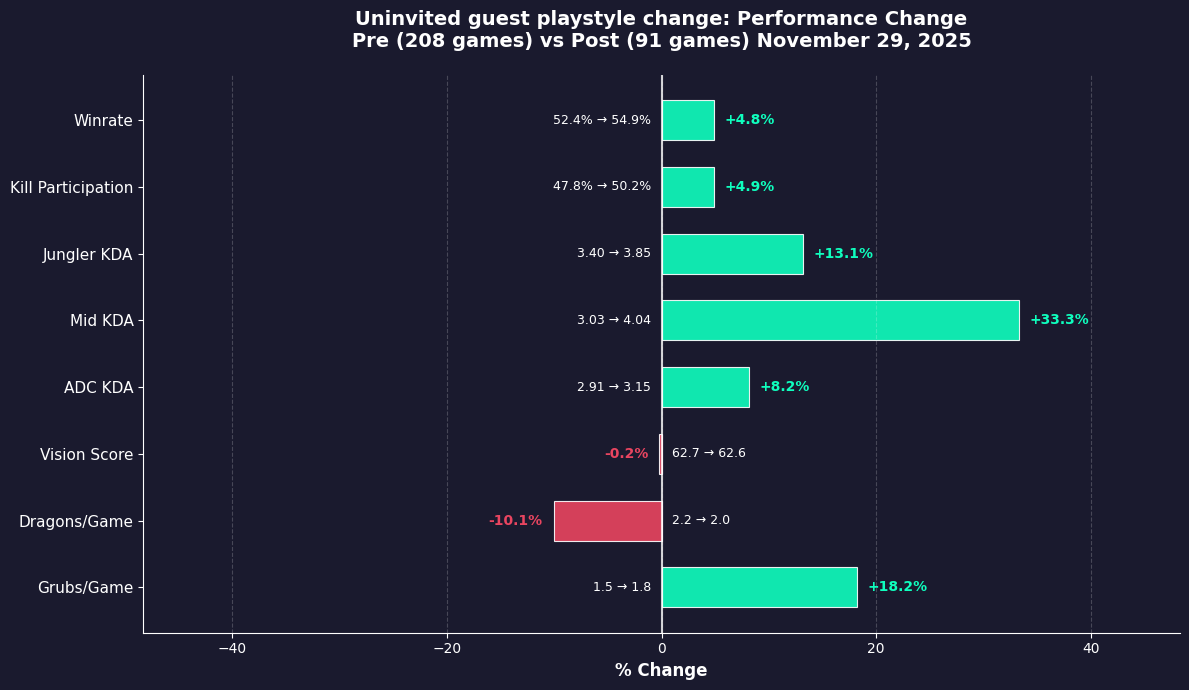


📊 DIAMOND BREAKTHROUGH SUMMARY
Metric                        Pre         Post          Change
---------------------------------------------------------------------------
Winrate                     52.40        54.95 ✅       +4.8%
Kill Participation          47.85        50.18 ✅       +4.9%
Jungler KDA                  3.40         3.85 ✅      +13.1%
Mid KDA                      3.03         4.04 ✅      +33.3%
ADC KDA                      2.91         3.15 ✅       +8.2%
Vision Score                62.75        62.60 ❌       -0.2%
Dragons/Game                 2.21         1.99 ❌      -10.1%
Grubs/Game                   1.54         1.82 ✅      +18.2%


In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
from datetime import datetime

# Load data
df = pd.read_csv('../data/lol_matches.csv')
df['gameDate'] = pd.to_datetime(df['gameDate'], utc=True)

with open('../data/lol_matches_raw.json', 'r') as f:
    raw_matches = json.load(f)
match_dict = {m['metadata']['matchId']: m for m in raw_matches}

# Define breakthrough date
BREAKTHROUGH = pd.Timestamp('2025-11-29', tz='UTC')

# Split data
pre = df[df['gameDate'] < BREAKTHROUGH]
post = df[df['gameDate'] >= BREAKTHROUGH]

print(f"Pre-breakthrough: {len(pre)} games ({pre['gameDate'].min().date()} to {pre['gameDate'].max().date()})")
print(f"Post-breakthrough: {len(post)} games ({post['gameDate'].min().date()} to {post['gameDate'].max().date()})")

# Get PUUID from first match
your_puuid = None
for m in raw_matches:
    for p in m['info']['participants']:
        if p['championName'] in df['championName'].values:
            your_puuid = p['puuid']
            break
    if your_puuid:
        break

# Function to extract team role performance and objectives from raw data
def analyze_period(period_df, match_dict, your_puuid):
    stats = {'dragons': [], 'grubs': [], 'jg_kda': [], 'mid_kda': [], 'adc_kda': [], 
             'jg_dmg': [], 'mid_dmg': [], 'adc_dmg': []}
    
    role_map = {'JUNGLE': 'jg', 'MIDDLE': 'mid', 'BOTTOM': 'adc'}
    
    for _, row in period_df.iterrows():
        match = match_dict.get(row['matchId'])
        if not match:
            continue
        
        your_team_id = row['teamId']
        participants = match['info']['participants']
        
        # Get objectives
        for team in match['info']['teams']:
            if team['teamId'] == your_team_id:
                stats['dragons'].append(team['objectives'].get('dragon', {}).get('kills', 0))
                stats['grubs'].append(team['objectives'].get('horde', {}).get('kills', 0))
        
        # Get teammate role performance (excluding yourself)
        for p in participants:
            if p['teamId'] == your_team_id and p['puuid'] != your_puuid:
                lane = p.get('teamPosition', p.get('lane', ''))
                role_key = role_map.get(lane)
                if role_key:
                    deaths = max(p['deaths'], 1)
                    kda = (p['kills'] + p['assists']) / deaths
                    stats[f'{role_key}_kda'].append(kda)
                    stats[f'{role_key}_dmg'].append(p['totalDamageDealtToChampions'])
    
    return {k: np.mean(v) if v else 0 for k, v in stats.items()}

pre_stats = analyze_period(pre, match_dict, your_puuid)
post_stats = analyze_period(post, match_dict, your_puuid)

# Compile comparison data (reversed order so highest appears at top of chart)
metrics = {
    'Grubs/Game': (pre_stats['grubs'], post_stats['grubs']),
    'Dragons/Game': (pre_stats['dragons'], post_stats['dragons']),
    'Vision Score': (pre['visionScore'].mean(), post['visionScore'].mean()),
    'ADC KDA': (pre_stats['adc_kda'], post_stats['adc_kda']),
    'Mid KDA': (pre_stats['mid_kda'], post_stats['mid_kda']),
    'Jungler KDA': (pre_stats['jg_kda'], post_stats['jg_kda']),
    'Kill Participation': (pre['killParticipation'].mean() * 100, post['killParticipation'].mean() * 100),
    'Winrate': (pre['win'].mean() * 100, post['win'].mean() * 100),
}

# Calculate percentage changes for normalized view
pct_changes = []
for metric, (pre_v, post_v) in metrics.items():
    pct = ((post_v - pre_v) / pre_v * 100) if pre_v != 0 else 0
    pct_changes.append((metric, pre_v, post_v, pct))

# Create visualization - normalized percentage change
fig, ax = plt.subplots(figsize=(12, 7))
fig.patch.set_facecolor('#1a1a2e')
ax.set_facecolor('#1a1a2e')

y_pos = np.arange(len(pct_changes))
changes = [p[3] for p in pct_changes]
colors = ['#0fffbe' if c >= 0 else '#e94560' for c in changes]

bars = ax.barh(y_pos, changes, color=colors, alpha=0.9, edgecolor='white', linewidth=0.8, height=0.6)

# Add value labels with pre/post values
for i, (metric, pre_v, post_v, pct) in enumerate(pct_changes):
    # Show actual values in parentheses
    if metric in ['Winrate', 'Kill Participation']:
        label = f'{pre_v:.1f}% → {post_v:.1f}%'
    elif 'KDA' in metric:
        label = f'{pre_v:.2f} → {post_v:.2f}'
    else:
        label = f'{pre_v:.1f} → {post_v:.1f}'
    
    # Position label on the appropriate side
    if pct >= 0:
        ax.text(pct + 1, i, f'+{pct:.1f}%', va='center', ha='left', fontsize=10, color='#0fffbe', fontweight='bold')
        ax.text(-1, i, label, va='center', ha='right', fontsize=9, color='white')
    else:
        ax.text(pct - 1, i, f'{pct:.1f}%', va='center', ha='right', fontsize=10, color='#e94560', fontweight='bold')
        ax.text(1, i, label, va='center', ha='left', fontsize=9, color='white')

ax.axvline(x=0, color='white', linestyle='-', linewidth=1.5, alpha=0.8)
ax.set_yticks(y_pos)
ax.set_yticklabels([p[0] for p in pct_changes], fontsize=11, color='white')
ax.set_xlabel('% Change', fontsize=12, color='white', fontweight='bold')
ax.set_title(f'Uninvited guest playstyle change: Performance Change\nPre ({len(pre)} games) vs Post ({len(post)} games) November 29, 2025', 
             fontsize=14, fontweight='bold', color='white', pad=20)
ax.tick_params(colors='white')
ax.spines['bottom'].set_color('white')
ax.spines['left'].set_color('white')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(axis='x', alpha=0.2, color='white', linestyle='--')

# Set symmetric x-axis limits
max_abs = max(abs(min(changes)), abs(max(changes))) + 15
ax.set_xlim(-max_abs, max_abs)

plt.tight_layout()
plt.show()

# Summary table
print("\n" + "="*75)
print("📊 DIAMOND BREAKTHROUGH SUMMARY")
print("="*75)
print(f"{'Metric':<20} {'Pre':>12} {'Post':>12} {'Change':>15}")
print("-"*75)
for metric, pre_v, post_v, pct in reversed(pct_changes):  # Reversed to show Winrate first
    symbol = "✅" if pct > 0 else "❌" if pct < 0 else "➖"
    print(f"{metric:<20} {pre_v:>12.2f} {post_v:>12.2f} {symbol} {pct:>+10.1f}%")


### Interpretation & Insights

The playstyle shift from "doing the most correct play for my team" to "doing the least correct play for the enemy team" translated into measurable improvements across multiple metrics. Here's what the data reveals:

**Objective Prioritization - Early Game Focus**:
The most satisfying change is the shift from late-game objectives (Dragons) to early-game objectives (Grubs). Dragons decreased by 10.1% while Grubs increased by 18.2%. This reflects the new playstyle's emphasis on creating early advantages and applying pressure where the enemy is unprepared. By prioritizing Grubs over Dragons, the strategy focuses on snowballing early leads rather than playing for late-game scaling.

**Vision Score - Unexpected Stability**:
Vision Score remained essentially unchanged (-0.2%), which was disappointing given the increased roaming and map presence. This suggests that while the playstyle involves more movement and skirmishing, the vision game remained consistent. The new approach may have shifted *where* vision is placed (prioritizing enemy weak points) rather than *how much* vision is placed overall.

**Role Performance - The Roaming Paradox**:
The most interesting finding is the ADC KDA improvement (+8.2%) despite significantly increased roaming. The expectation was that leaving the ADC alone more often would hurt their performance, but the opposite occurred. This suggests that the new playstyle creates advantages elsewhere on the map that benefit the entire team, including the ADC. The increased Mid KDA (+33.3%) and Jungler KDA (+13.1%) show that the roaming and skirmishing approach is working really well.

**Overall Impact**:
The combination of improved winrate (+4.8%), kill participation (+4.9%), and role-specific KDA improvements across Mid, Jungle, and ADC shows that the "uninvited guest" playstyle creates cascading benefits for all teammates. By focusing on creating problems for the enemy rather than solving problems for your team, the strategy generates pressure that benefits everyone, even roles that might seem disconnected from the roaming playstyle.


---

## Calendar Grid Heatmap 

GitHub-style calendar showing daily W/L


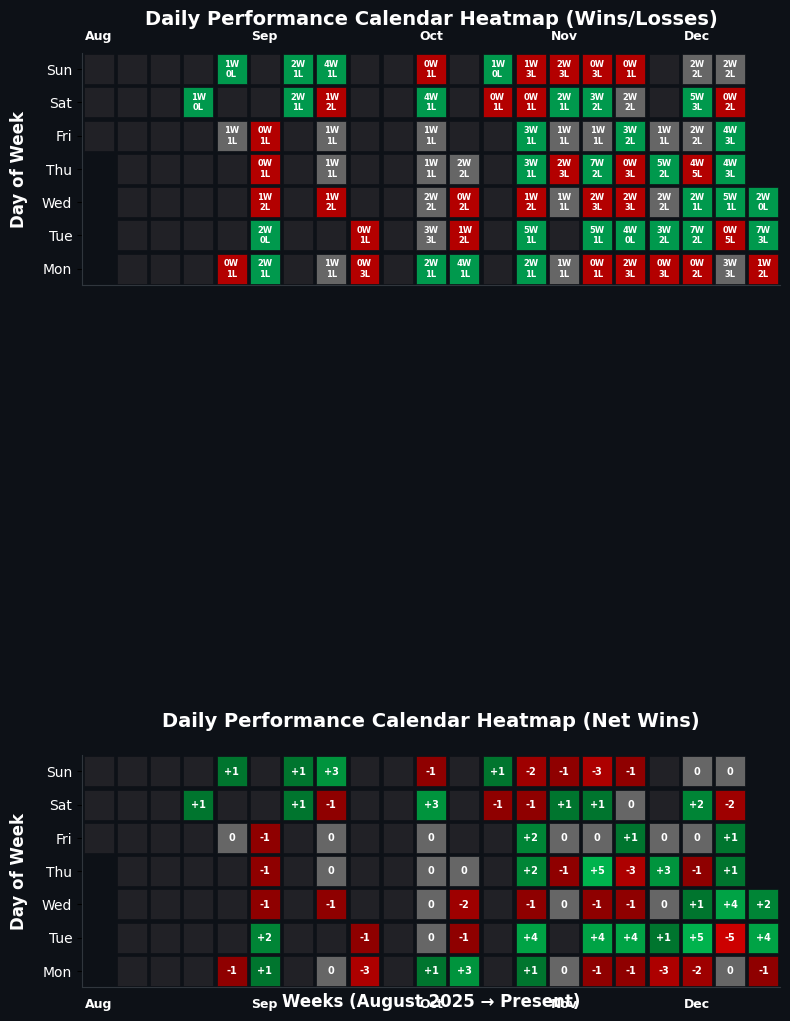


📊 CALENDAR HEATMAP SUMMARY
Date range: 2025-08-01 to 2025-12-17
Total days tracked: 139
Days played: 81 (58.3%)
Win days: 31 (38.3% of played days)
Loss days: 30 (37.0% of played days)
Neutral days: 20 (24.7% of played days)
Average win day: +2.2 net wins
Average loss day: -1.5 net wins
Days without games: 58


In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from datetime import datetime, timedelta
import calendar

# Load data
df = pd.read_csv('../data/lol_matches.csv')
df['gameDate'] = pd.to_datetime(df['gameDate'], utc=True)

# Group by date and calculate daily stats
df['date'] = df['gameDate'].dt.date
daily_stats = df.groupby('date').agg({
    'win': ['sum', 'count']
}).reset_index()
daily_stats.columns = ['date', 'wins', 'total']
daily_stats['losses'] = daily_stats['total'] - daily_stats['wins']
daily_stats['net_wins'] = daily_stats['wins'] - daily_stats['losses']

# Create date range from August 2025 to end of data
start_date = pd.Timestamp('2025-08-01').date()
end_date = daily_stats['date'].max()

# Create a complete dataframe with all dates
all_dates = pd.date_range(start=start_date, end=end_date, freq='D')
calendar_df = pd.DataFrame({'date': all_dates.date})
calendar_df = calendar_df.merge(daily_stats, on='date', how='left')
calendar_df['wins'] = calendar_df['wins'].fillna(0).astype(int)
calendar_df['losses'] = calendar_df['losses'].fillna(0).astype(int)
calendar_df['total'] = calendar_df['total'].fillna(0).astype(int)
calendar_df['net_wins'] = calendar_df['net_wins'].fillna(0).astype(int)
calendar_df['played'] = calendar_df['total'] > 0

# Add day of week and week number
calendar_df['weekday'] = pd.to_datetime(calendar_df['date']).dt.dayofweek
calendar_df['year'] = pd.to_datetime(calendar_df['date']).dt.year
calendar_df['month'] = pd.to_datetime(calendar_df['date']).dt.month
calendar_df['day'] = pd.to_datetime(calendar_df['date']).dt.day

# Calculate week number (weeks starting on Monday)
calendar_df['week'] = pd.to_datetime(calendar_df['date']).dt.isocalendar().week
calendar_df['year_week'] = calendar_df['year'].astype(str) + '-' + calendar_df['week'].astype(str).str.zfill(2)

# Get unique year-weeks and sort
unique_weeks = sorted(calendar_df['year_week'].unique())
week_to_idx = {week: idx for idx, week in enumerate(unique_weeks)}

# Create the grid: rows = days of week (Mon=0 to Sun=6), cols = weeks (vertical layout)
max_weeks = len(unique_weeks)
grid = np.full((7, max_weeks), np.nan)  # NaN for days that don't exist
grid_played = np.zeros((7, max_weeks), dtype=bool)
grid_net_wins = np.zeros((7, max_weeks), dtype=int)
grid_wins = np.zeros((7, max_weeks), dtype=int)
grid_losses = np.zeros((7, max_weeks), dtype=int)

for _, row in calendar_df.iterrows():
    week_idx = week_to_idx[row['year_week']]
    weekday = row['weekday']
    grid[weekday, week_idx] = row['net_wins']
    grid_played[weekday, week_idx] = row['played']
    grid_net_wins[weekday, week_idx] = row['net_wins']
    grid_wins[weekday, week_idx] = row['wins']
    grid_losses[weekday, week_idx] = row['losses']

# Create visualization with two subplots (W/L and Net Wins)
fig, axes = plt.subplots(2, 1, figsize=(max(8, max_weeks * 0.3), 18))
fig.patch.set_facecolor('#0d1117')

# First subplot: W/L display
ax1 = axes[0]
ax1.set_facecolor('#0d1117')

# Create color map - green for wins, red for losses, gray for neutral/no games (no intensity variations)
colors = np.full((7, max_weeks, 4), [0.13, 0.13, 0.15, 1.0])  # Default dark gray for no games

for i in range(7):  # Days of week
    for j in range(max_weeks):  # Weeks
        if grid_played[i, j]:
            net = grid_net_wins[i, j]
            if net > 0:
                # Green for win days (same shade for all)
                colors[i, j] = [0.0, 0.6, 0.3, 1.0]
            elif net < 0:
                # Red for loss days (same shade for all)
                colors[i, j] = [0.7, 0.0, 0.0, 1.0]
            else:
                # Neutral gray for even days
                colors[i, j] = [0.4, 0.4, 0.4, 1.0]

# Draw squares
square_size = 0.9
for i in range(7):  # Days of week
    for j in range(max_weeks):  # Weeks
        if not np.isnan(grid[i, j]):
            rect = mpatches.Rectangle((j - square_size/2, i - square_size/2), 
                                     square_size, square_size,
                                     facecolor=colors[i, j], 
                                     edgecolor='#0d1117', linewidth=0.5)
            ax1.add_patch(rect)
            
            # Add text for days with games
            if grid_played[i, j]:
                wins = int(grid_wins[i, j])
                losses = int(grid_losses[i, j])
                # Show label for all days with games
                ax1.text(j, i, f'{wins}W\n{losses}L', ha='center', va='center', 
                       fontsize=6, color='white', fontweight='bold')

# Set up axes for W/L plot
ax1.set_xlim(-0.5, max_weeks - 0.5)
ax1.set_ylim(-0.5, 6.5)
ax1.set_aspect('equal')

# Day labels on y-axis (vertical)
ax1.set_yticks(range(7))
ax1.set_yticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'], 
                   fontsize=10, color='white')
ax1.set_ylabel('Day of Week', fontsize=12, color='white', fontweight='bold', labelpad=10)

# Week labels on x-axis
ax1.set_xticks([])

# Add month labels on the top
current_month = None
month_labels = []
month_positions = []
for j, week in enumerate(unique_weeks):
    # Get a date from this week to determine month
    week_date = calendar_df[calendar_df['year_week'] == week]['date'].iloc[0]
    month = pd.to_datetime(week_date).month
    month_name = calendar.month_abbr[month]
    
    if month != current_month:
        month_labels.append(month_name)
        month_positions.append(j)
        current_month = month

# Add month labels on top
for month, pos in zip(month_labels, month_positions):
    ax1.text(pos, 6.8, month, ha='center', va='bottom', fontsize=9, 
           color='white', fontweight='bold')

ax1.set_title('Daily Performance Calendar Heatmap (Wins/Losses)', 
             fontsize=14, fontweight='bold', color='white', pad=20)

ax1.spines['bottom'].set_color('#30363d')
ax1.spines['left'].set_color('#30363d')
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

# Second subplot: Net Wins display
ax2 = axes[1]
ax2.set_facecolor('#0d1117')

# Create color map for net wins with intensity
colors_net = np.full((7, max_weeks, 4), [0.13, 0.13, 0.15, 1.0])  # Default dark gray for no games

# Find max absolute net wins for color scaling
max_net = max(abs(grid_net_wins.max()), abs(grid_net_wins.min())) if grid_net_wins.max() > 0 or grid_net_wins.min() < 0 else 1

for i in range(7):  # Days of week
    for j in range(max_weeks):  # Weeks
        if grid_played[i, j]:
            net = grid_net_wins[i, j]
            if net > 0:
                # Green with intensity based on net wins
                intensity = min(net / max_net, 1.0)
                colors_net[i, j] = [0.0, 0.4 + 0.3 * intensity, 0.15 + 0.15 * intensity, 1.0]
            elif net < 0:
                # Red with intensity based on net losses
                intensity = min(abs(net) / max_net, 1.0)
                colors_net[i, j] = [0.5 + 0.3 * intensity, 0.0, 0.0, 1.0]
            else:
                # Neutral gray for even days
                colors_net[i, j] = [0.4, 0.4, 0.4, 1.0]

# Draw squares for net wins
for i in range(7):  # Days of week
    for j in range(max_weeks):  # Weeks
        if not np.isnan(grid[i, j]):
            rect = mpatches.Rectangle((j - square_size/2, i - square_size/2), 
                                     square_size, square_size,
                                     facecolor=colors_net[i, j], 
                                     edgecolor='#0d1117', linewidth=0.5)
            ax2.add_patch(rect)
            
            # Add text for days with games showing net wins
            if grid_played[i, j]:
                net = grid_net_wins[i, j]
                if net != 0:
                    sign = '+' if net > 0 else ''
                    ax2.text(j, i, f'{sign}{net}', ha='center', va='center', 
                           fontsize=7, color='white', fontweight='bold')
                else:
                    ax2.text(j, i, '0', ha='center', va='center', 
                           fontsize=7, color='white', fontweight='bold')

# Set up axes for net wins plot
ax2.set_xlim(-0.5, max_weeks - 0.5)
ax2.set_ylim(-0.5, 6.5)
ax2.set_aspect('equal')

# Day labels on y-axis (vertical)
ax2.set_yticks(range(7))
ax2.set_yticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'], 
                   fontsize=10, color='white')
ax2.set_ylabel('Day of Week', fontsize=12, color='white', fontweight='bold', labelpad=10)

# Week labels on x-axis
ax2.set_xticks([])
ax2.set_xlabel('Weeks (August 2025 → Present)', fontsize=12, color='white', fontweight='bold')

# Add month labels on the bottom
for month, pos in zip(month_labels, month_positions):
    ax2.text(pos, -0.8, month, ha='center', va='top', fontsize=9, 
           color='white', fontweight='bold')

ax2.set_title('Daily Performance Calendar Heatmap (Net Wins)', 
             fontsize=14, fontweight='bold', color='white', pad=20)

ax2.spines['bottom'].set_color('#30363d')
ax2.spines['left'].set_color('#30363d')
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

# Summary stats
total_days = len(calendar_df)
days_played = calendar_df['played'].sum()
win_days = (calendar_df['net_wins'] > 0).sum()
loss_days = (calendar_df['net_wins'] < 0).sum()
neutral_days = (calendar_df['net_wins'] == 0).sum() - (total_days - days_played)

# Calculate average win day and average loss day
win_days_data = calendar_df[calendar_df['net_wins'] > 0]
loss_days_data = calendar_df[calendar_df['net_wins'] < 0]

avg_win_day = win_days_data['net_wins'].mean() if len(win_days_data) > 0 else 0
avg_loss_day = abs(loss_days_data['net_wins'].mean()) if len(loss_days_data) > 0 else 0

print("\n" + "="*70)
print("📊 CALENDAR HEATMAP SUMMARY")
print("="*70)
print(f"Date range: {start_date} to {end_date}")
print(f"Total days tracked: {total_days}")
print(f"Days played: {days_played} ({days_played/total_days*100:.1f}%)")
if days_played > 0:
    print(f"Win days: {win_days} ({win_days/days_played*100:.1f}% of played days)")
    print(f"Loss days: {loss_days} ({loss_days/days_played*100:.1f}% of played days)")
    print(f"Neutral days: {neutral_days} ({neutral_days/days_played*100:.1f}% of played days)")
    if len(win_days_data) > 0:
        print(f"Average win day: +{avg_win_day:.1f} net wins")
    if len(loss_days_data) > 0:
        print(f"Average loss day: -{avg_loss_day:.1f} net wins")
print(f"Days without games: {total_days - days_played}")


### Interpretation & Insights

The calendar heatmap reveals a clear pattern in daily performance that aligns with the overall progression toward Diamond:

**Win Streaks vs Loss Streaks**:
The data shows a significant asymmetry: win days average **+2.2 net wins** while loss days average **-1.5 net wins**. This means that when you're winning, you're winning big—often having days with 5+ net wins (like 7W-2L = +5). Conversely, loss days tend to be smaller in magnitude, rarely exceeding -3 or -4 net losses. This pattern suggests that when you're in form, you can string together multiple wins in a single day, creating substantial rank gains. When you're struggling, losses are more contained, preventing catastrophic rank drops.

**Performance Distribution**:
The breakdown shows a relatively balanced distribution: 38.3% win days, 37.0% loss days, and 24.7% neutral days. However, the magnitude difference (average +2.2 vs -1.5) means that even with roughly equal numbers of win and loss days, the overall trajectory is positive. This is the mathematical foundation of rank progression—not just winning more days, but winning bigger when you do win.

**Visual Pattern**:
Looking at the calendar progression, there's a noticeable shift from more mixed/red days in August-September to more concentrated green days in November-December. This aligns with the Diamond breakthrough analysis, showing that the playstyle shift in late November translated into more consistent winning days. The net wins visualization makes this even clearer—you can see days with +5, +6, or even +7 net wins becoming more common in the later months, while the red days remain relatively small in magnitude.

**Key Insight**:
The ability to have explosive win days (+5 to +7 net wins) while keeping loss days contained (-1 to -3 net losses) is a hallmark of consistent improvement. This pattern suggests that when you're playing well, you can capitalize and extend winning streaks, while when you're struggling, you're able to recognize it and stop before losses compound. This discipline in loss management, combined with the ability to maximize win streaks, is what enabled the climb from Emerald 4 to Diamond 4.
